In [ ]:
# %%

import numpy as np
import matplotlib.pyplot as plt
from shared_simulator import (
    NodeReputationSimulator,
    NodeReliability,
    NetworkSimulator,
    run_notebook_simulation,
    scenario_reliable_then_failing,
    scenario_gradual_degradation,
)

# by default make matplotlib use dark mode
# plt.style.use("dark_background")
# make the maplotlibs high dpi
plt.rcParams["figure.dpi"] = 150

# set np random seed for reproducibility
# convert string to seed
seed = "storb"
seed = sum(ord(c) for c in seed) % (2**32 - 1)
np.random.seed(seed)

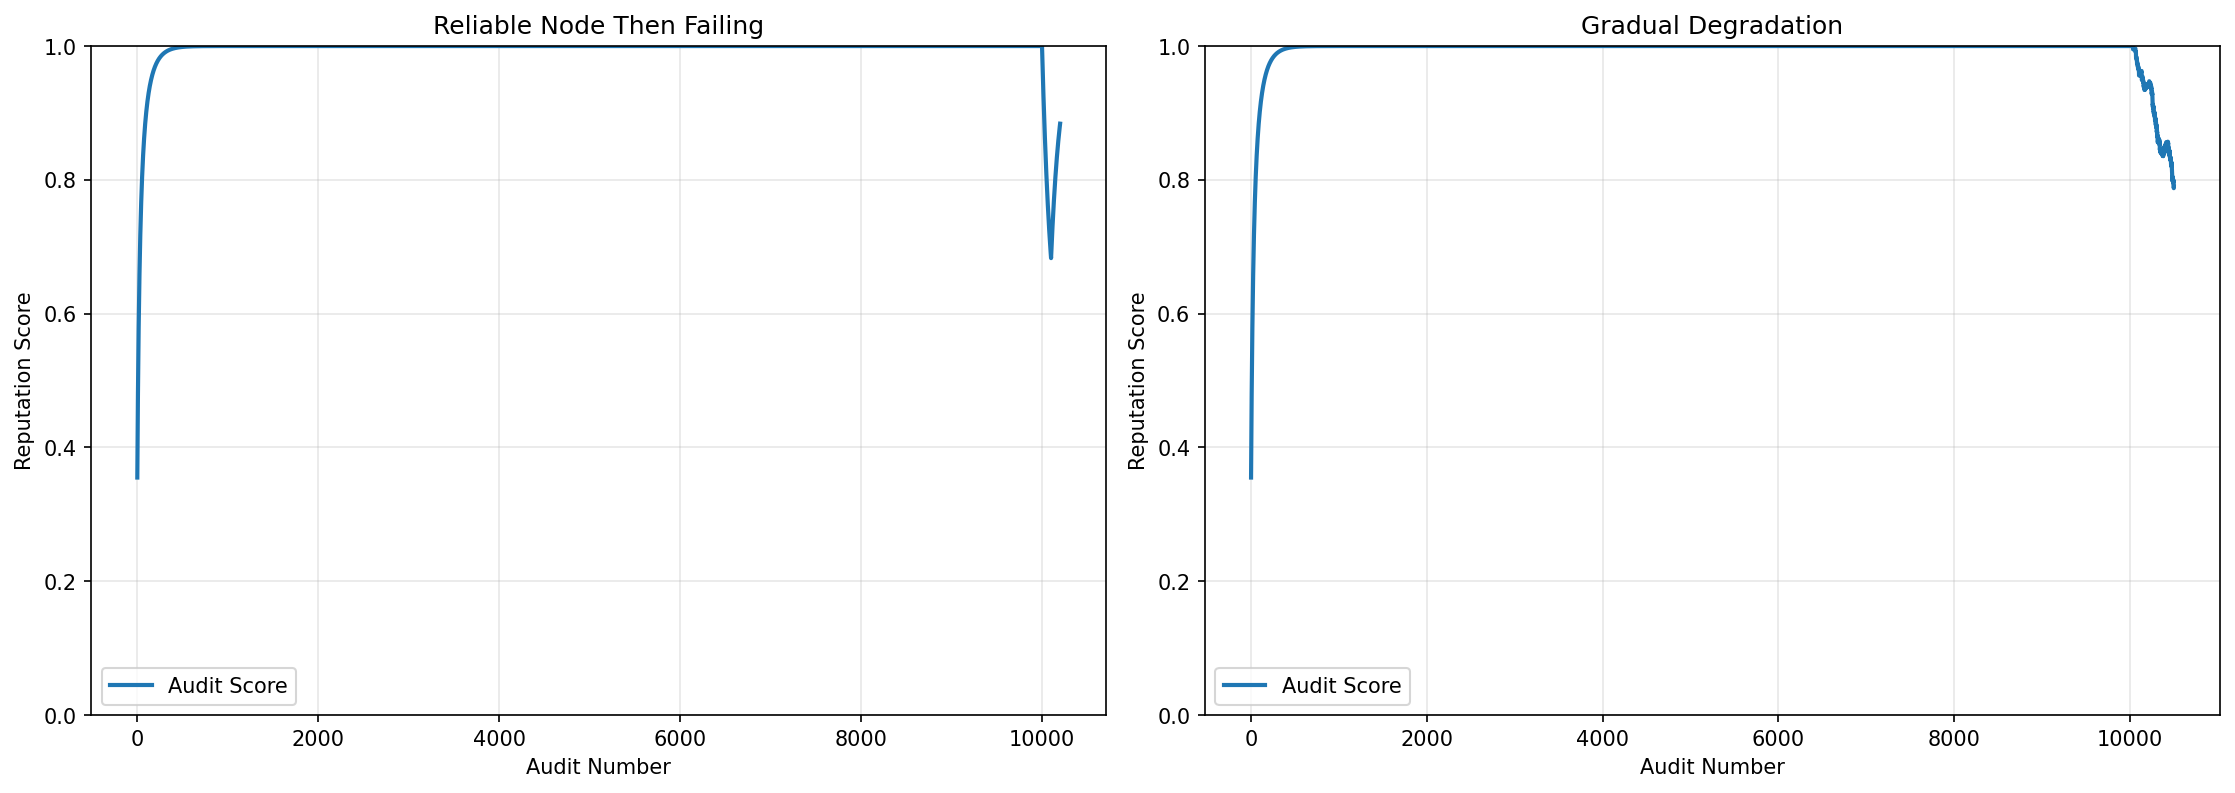

In [ ]:
# %%

# Legacy scenario testing using individual node simulators
def test_individual_node_scenarios():
    """Test individual node scenarios (legacy functionality)"""
    # Create a simulator for individual node testing
    simulator = NodeReputationSimulator()

    scenarios = [
        ("Reliable Node Then Failing", scenario_reliable_then_failing()),
        ("Gradual Degradation", scenario_gradual_degradation()),
    ]

    plt.figure(figsize=(15, 10))

    for i, (name, events) in enumerate(scenarios):
        # Reset simulator for each scenario
        simulator.__init__()

        # Simulate events
        for event in events:
            simulator.apply_audit_result(event["type"])

        plt.subplot(2, 2, i + 1)
        audit_scores = [h["audit_score"] for h in simulator.history]

        plt.plot(audit_scores, label="Audit Score", linewidth=2)

        plt.title(name)
        plt.xlabel("Audit Number")
        plt.ylabel("Reputation Score")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()


# Run the individual scenario tests
test_individual_node_scenarios()

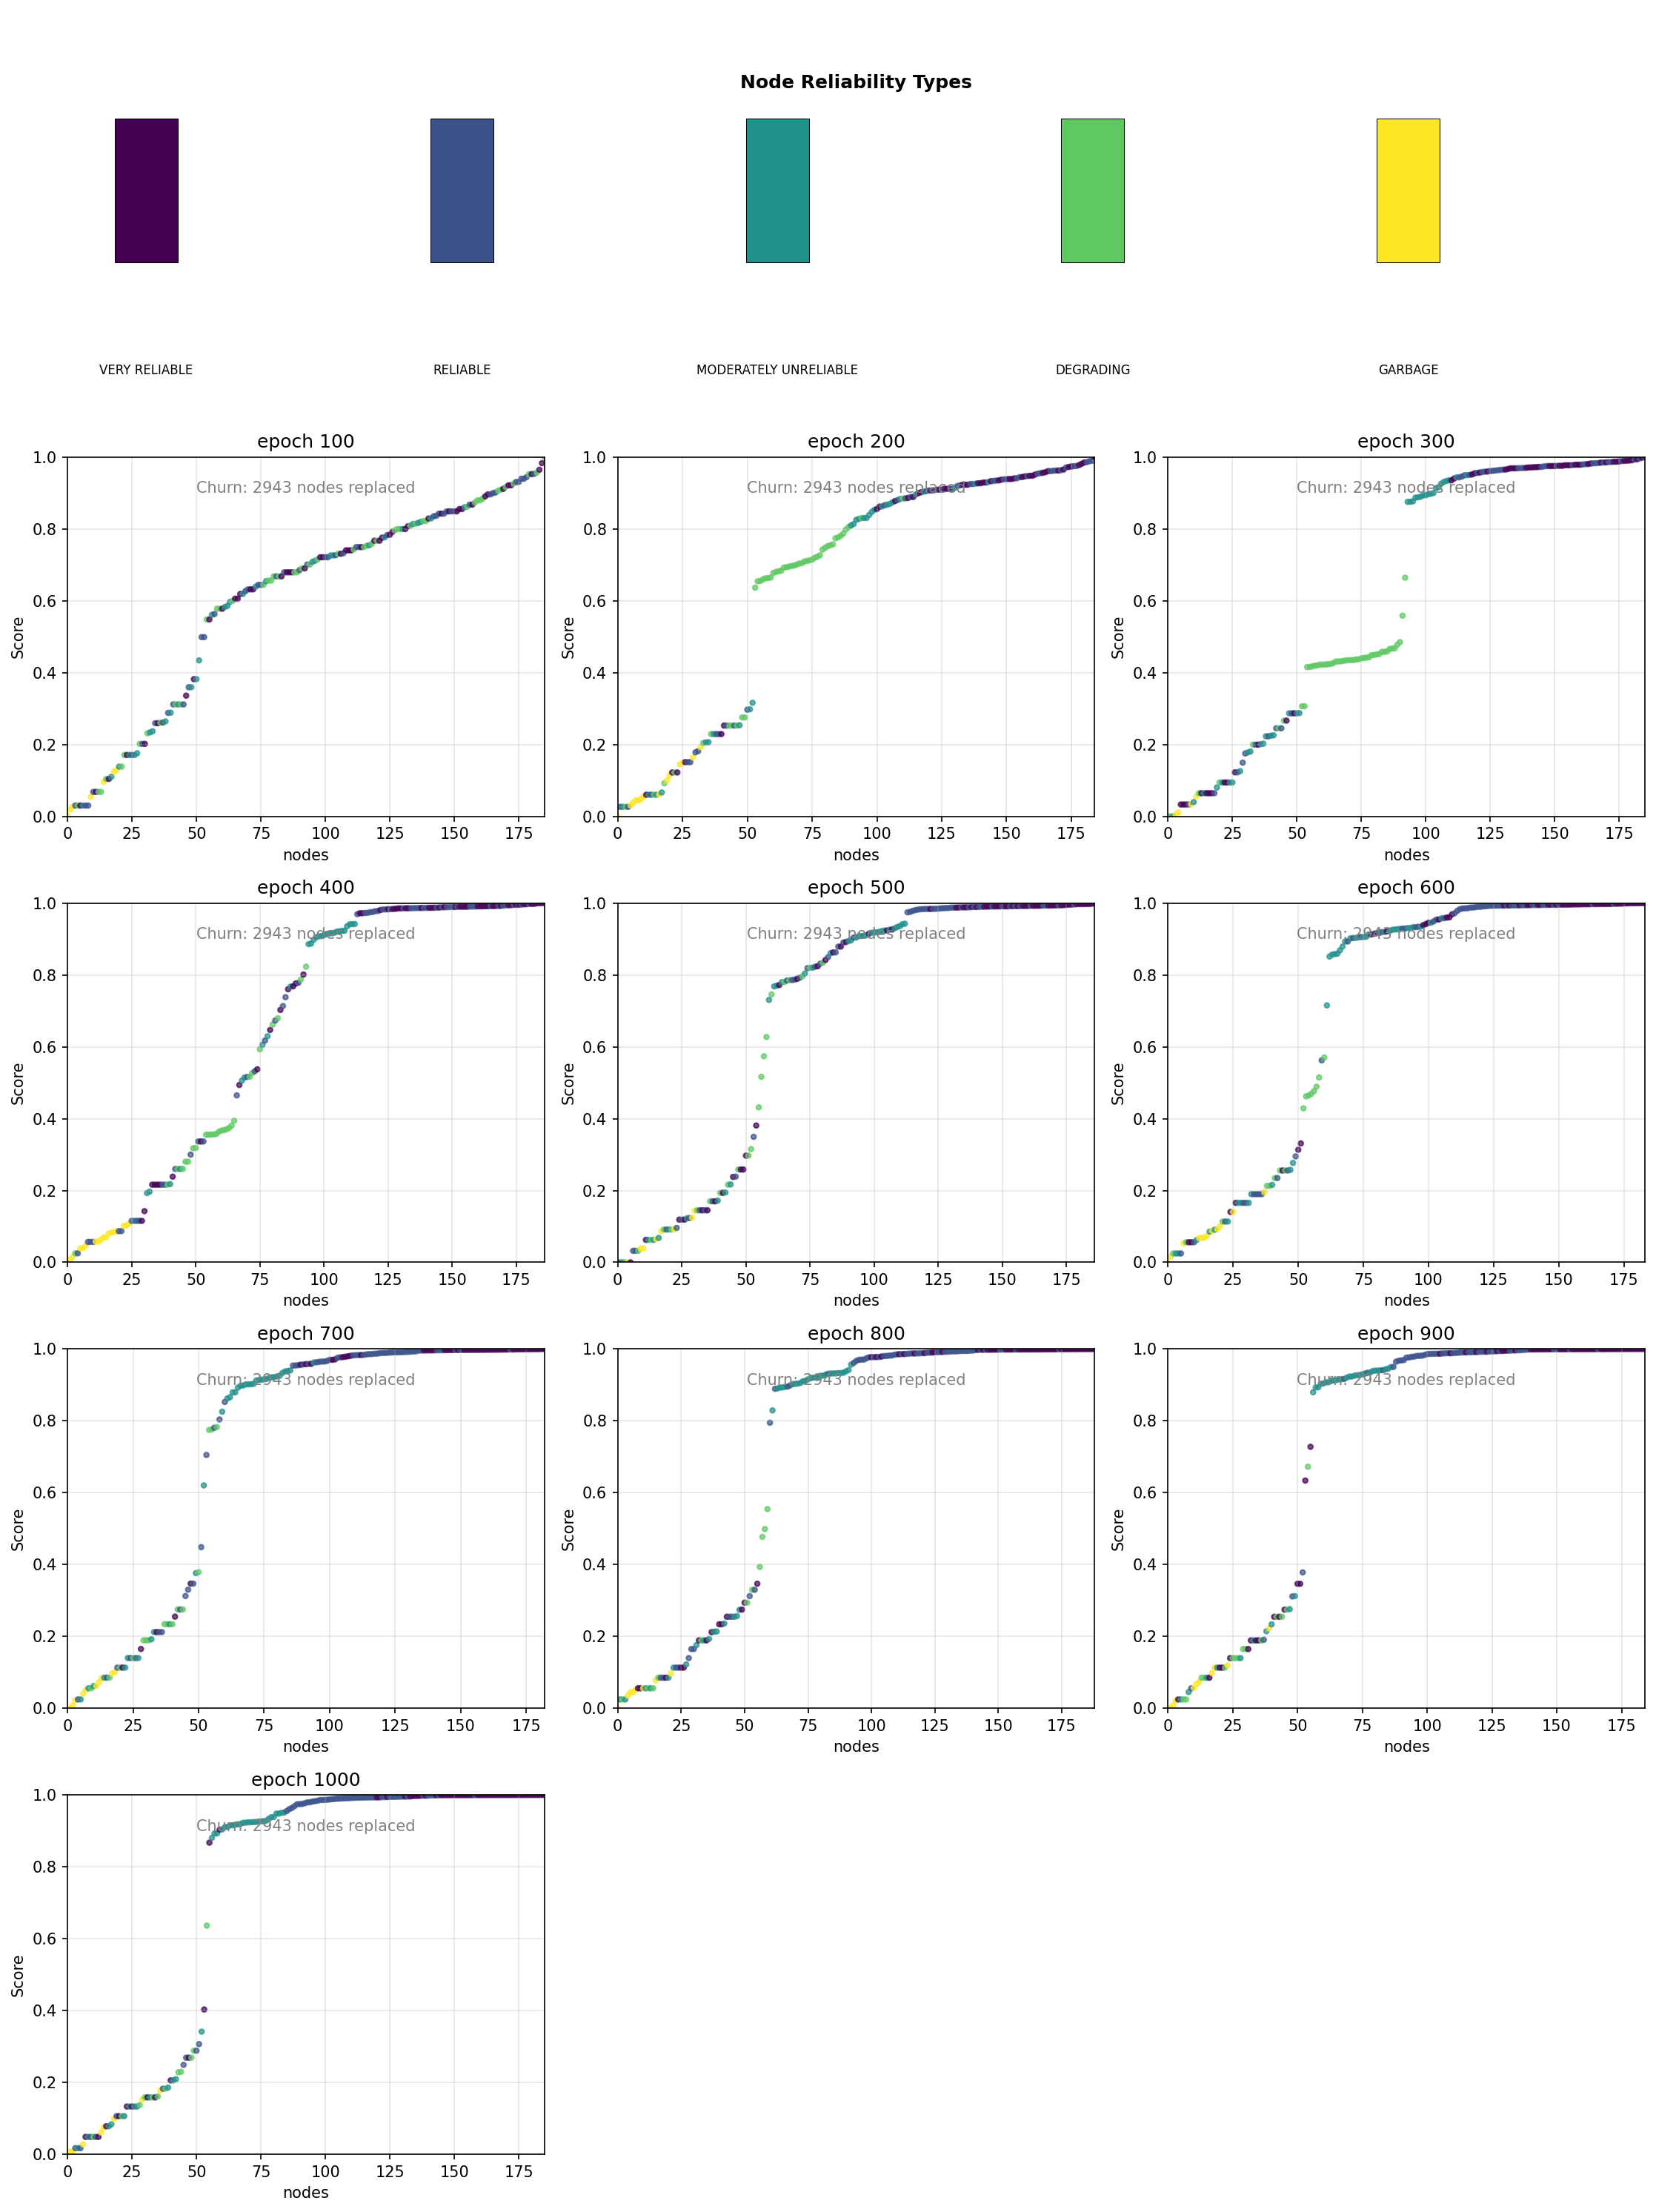

In [ ]:
# %%

def plot_network_simulation_snapshots():
    """Run network simulation and plot snapshots at different epochs with sorted node scores"""

    # Run simulation with new zero-start behavior
    config = {
        "num_nodes_target": 192,
        "epochs": 1000,
        "nodes_per_epoch_add": 3,
        "nodes_per_epoch_churn": 3,
        "min_epochs_before_churn": 20,
        # "min_epochs_before_churn": 15,
        "num_nodes_per_piece_upload": 25,
        # "num_nodes_per_piece_upload": 10,
        "num_piece_per_upload": 4,
        "num_pieces_download_per_audit": 5,
        "num_nodes_per_piece_download": 4,
    }

    result = run_notebook_simulation(config)
    epoch_data = result["epoch_data"]
    churn_events = result["churn_events"]

    # Plot snapshots at specific epochs to match notebook style
    epochs_to_plot = np.arange(100, config["epochs"] + 1, 100).tolist()

    # Create snapshot plots
    num_plots = len(epochs_to_plot)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig = plt.figure(figsize=(15, 5 * num_rows))

    # Create reliability color mapping and legend
    reliability_map = {
        "VERY_RELIABLE": 1,
        "RELIABLE": 2,
        "MODERATELY_UNRELIABLE": 3,
        "DEGRADING": 4,
        "GARBAGE": 5,
    }

    # Create a colorbar/legend at the top of the figure
    # Add a subplot at the top for the legend
    legend_ax = fig.add_subplot(num_rows + 1, 1, 1)
    legend_ax.set_xlim(0, 10)
    legend_ax.set_ylim(0, 1)
    legend_ax.axis("off")

    # Create legend elements
    from matplotlib.patches import Rectangle
    import matplotlib.cm as cm

    # Get viridis colormap
    viridis = cm._colormaps.get_cmap("viridis")

    # Create legend entries
    legend_elements = []
    legend_labels = []
    x_positions = [0.5, 2.5, 4.5, 6.5, 8.5]

    for i, (reliability_name, color_value) in enumerate(reliability_map.items()):
        # Normalize color value to 0-1 range for colormap
        normalized_color = (color_value - 1) / 4  # Since values are 1-5
        color = viridis(normalized_color)

        # Add colored rectangle
        rect = Rectangle(
            (x_positions[i] - 0.2, 0.3),
            0.4,
            0.4,
            facecolor=color,
            edgecolor="black",
            linewidth=0.5,
        )
        legend_ax.add_patch(rect)

        # Add text label
        legend_ax.text(
            x_positions[i],
            0.0,
            reliability_name.replace("_", " "),
            ha="center",
            va="center",
            fontsize=8,
            rotation=0,
        )

    # Add title for legend
    legend_ax.text(
        5,
        0.8,
        "Node Reliability Types",
        ha="center",
        va="center",
        fontsize=12,
        fontweight="bold",
        color="black",
    )

    # Adjust subplot positioning to make room for legend
    # plt.subplots_adjust(top=0.0, hspace=0.0)

    for i, target_epoch in enumerate(epochs_to_plot):
        # Find the closest epoch data
        epoch_idx = min(target_epoch - 1, len(epoch_data) - 1)
        if epoch_idx < 0:
            continue

        data = epoch_data[epoch_idx]
        # Adjust subplot index to account for legend
        ax = fig.add_subplot(num_rows + 1, num_cols, i + num_cols + 1)

        if data["nodes"]:
            # Extract scores and reliability data
            node_scores = [node["y"] for node in data["nodes"]]
            node_reliability = [node["reliability"] for node in data["nodes"]]

            # Create tuples of (score, reliability) and sort by score
            node_data = list(zip(node_scores, node_reliability))
            node_data.sort(key=lambda x: x[0])  # Sort by score (ascending)

            # Extract sorted data
            sorted_scores = [item[0] for item in node_data]
            sorted_reliability = [item[1] for item in node_data]

            # Normalize scores like in the notebook (optional - can be removed if you want raw scores)
            if len(set(sorted_scores)) > 1:  # Avoid division by zero
                min_score = min(sorted_scores)
                max_score = max(sorted_scores)
                normalized_scores = [
                    (score - min_score) / (max_score - min_score)
                    for score in sorted_scores
                ]
            else:
                # All scores are the same
                normalized_scores = [0.0] * len(sorted_scores)

            colors = [reliability_map[rel] for rel in sorted_reliability]

            # Plot with normalized scores (change to sorted_scores for raw scores)
            scatter = ax.scatter(
                range(len(normalized_scores)),
                normalized_scores,  # or sorted_scores for raw values
                c=colors,
                cmap="viridis",
                s=10,
                alpha=0.7,
            )

            ax.set_title(f"epoch {data['epoch']}")
            ax.set_xlim(0, len(normalized_scores) - 1)
            ax.set_xlabel("nodes")
            ax.set_ylabel("Score")
            ax.grid(True, alpha=0.3)
            ax.set_ylim(0, 1)

            # Add statistics text like in notebook
            ax.text(
                0.5,
                0.9,
                f"Churn: {len(churn_events)} nodes replaced",
                transform=ax.transAxes,
                ha="center",
                fontsize=10,
                color="gray",
            )
        else:
            # No nodes yet
            ax.set_title(f"epoch {data['epoch']}")
            ax.set_xlabel("nodes")
            ax.set_ylabel("Score")
            ax.grid(True, alpha=0.3)
            ax.set_ylim(0, 1)
            ax.text(
                0.5,
                0.5,
                "No nodes yet",
                transform=ax.transAxes,
                ha="center",
                va="center",
                fontsize=12,
                color="gray",
            )

    plt.tight_layout()
    plt.show()

    return result


# Run the network simulation
result = plot_network_simulation_snapshots()

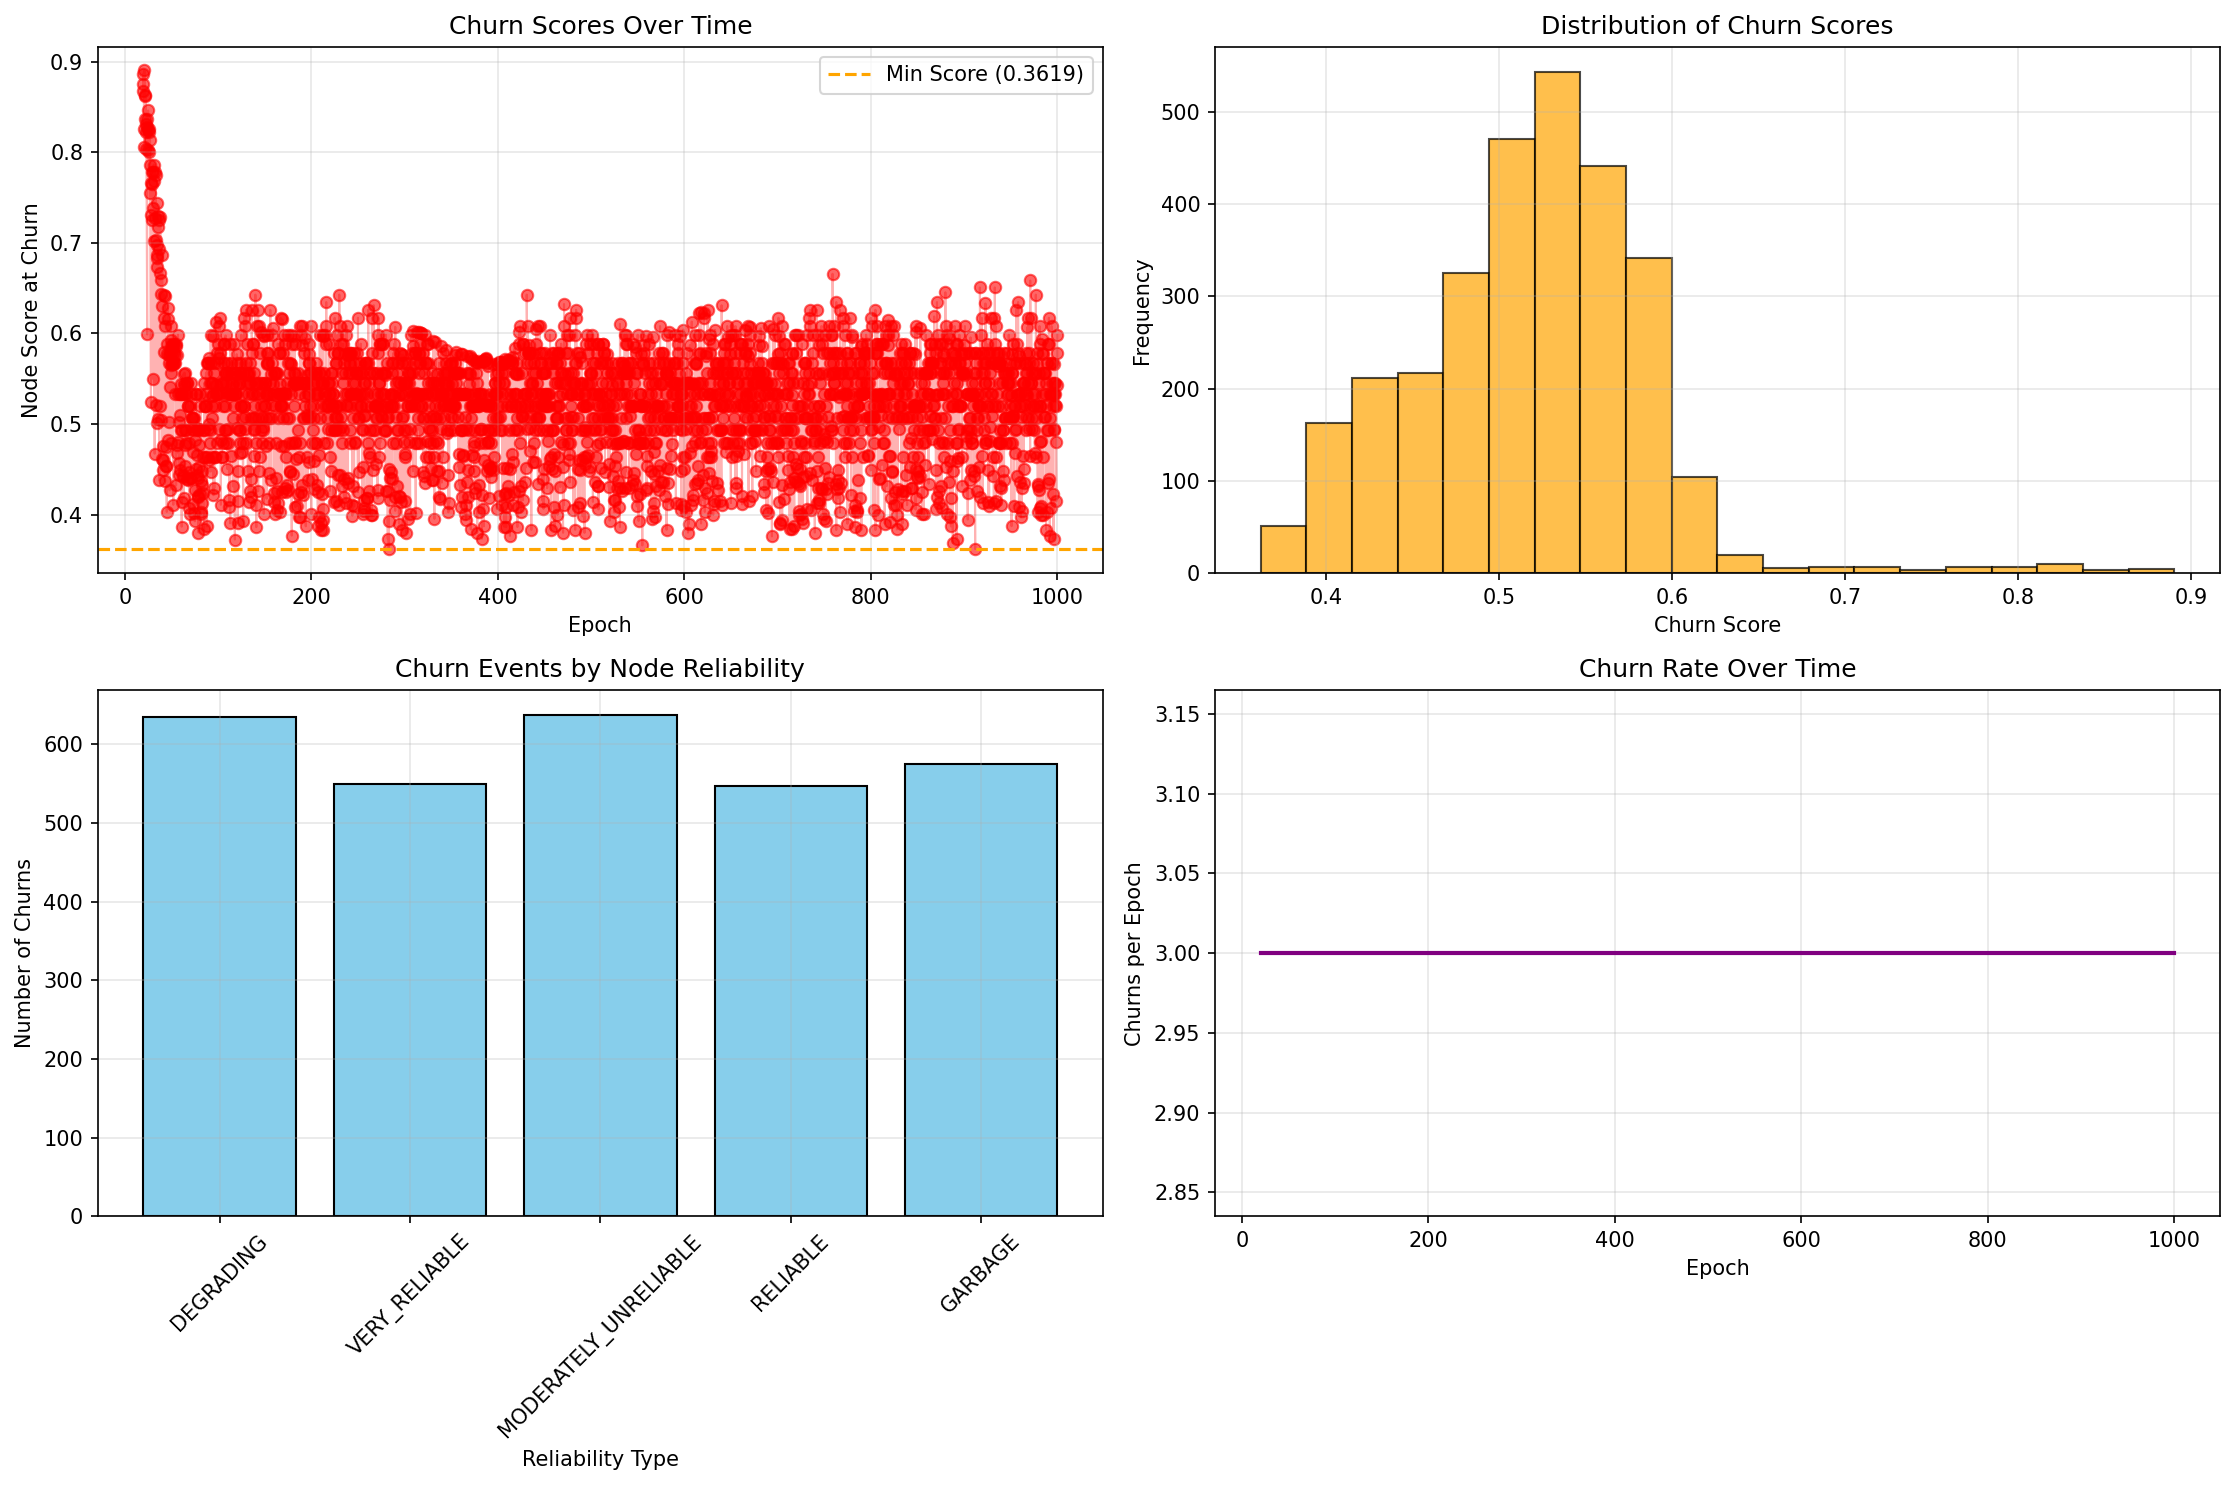


Churn Analysis Summary:
Total churn events: 2943
Average churn score: 0.5202
Churn score std dev: 0.0677
Min churn score: 0.3619
Max churn score: 0.8904

Churn by reliability type:
  DEGRADING: 635 (21.6%)
  VERY_RELIABLE: 549 (18.7%)
  MODERATELY_UNRELIABLE: 637 (21.6%)
  RELIABLE: 547 (18.6%)
  GARBAGE: 575 (19.5%)


In [ ]:
# %%

def analyze_churn_patterns(result):
    """Analyze and visualize churn patterns"""
    churn_events = result["churn_events"]

    if not churn_events:
        print("No churn events to analyze")
        return

    # Extract churn data
    churn_epochs = [event["epoch"] for event in churn_events]
    churn_scores = [event["score"] for event in churn_events]
    churn_reliability = [event["reliability"] for event in churn_events]

    # Create analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Churn scores over time
    axes[0, 0].scatter(churn_epochs, churn_scores, alpha=0.6, s=27, color="red")
    axes[0, 0].plot(churn_epochs, churn_scores, alpha=0.3, color="red", linewidth=1)
    axes[0, 0].set_title("Churn Scores Over Time")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Node Score at Churn")
    axes[0, 0].grid(True, alpha=0.3)

    if churn_scores:
        min_score = min(churn_scores)
        axes[0, 0].axhline(
            y=min_score,
            color="orange",
            linestyle="--",
            label=f"Min Score ({min_score:.4f})",
        )
        axes[0, 0].legend()

    # Plot 2: Distribution of churn scores
    axes[0, 1].hist(churn_scores, bins=20, alpha=0.7, color="orange", edgecolor="black")
    axes[0, 1].set_title("Distribution of Churn Scores")
    axes[0, 1].set_xlabel("Churn Score")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Churn by reliability type
    reliability_counts = {}
    for rel in churn_reliability:
        reliability_counts[rel] = reliability_counts.get(rel, 0) + 1

    rel_names = list(reliability_counts.keys())
    rel_counts = list(reliability_counts.values())

    axes[1, 0].bar(rel_names, rel_counts, color="skyblue", edgecolor="black")
    axes[1, 0].set_title("Churn Events by Node Reliability")
    axes[1, 0].set_xlabel("Reliability Type")
    axes[1, 0].set_ylabel("Number of Churns")
    axes[1, 0].tick_params(axis="x", rotation=45)
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Churn rate over time (churns per epoch)
    epoch_churn_counts = {}
    for epoch in churn_epochs:
        epoch_churn_counts[epoch] = epoch_churn_counts.get(epoch, 0) + 1

    epochs = sorted(epoch_churn_counts.keys())
    churn_rates = [epoch_churn_counts[epoch] for epoch in epochs]

    axes[1, 1].plot(epochs, churn_rates, color="purple", linewidth=2)
    axes[1, 1].set_title("Churn Rate Over Time")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Churns per Epoch")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\nChurn Analysis Summary:")
    print(f"Total churn events: {len(churn_events)}")
    print(f"Average churn score: {np.mean(churn_scores):.4f}")
    print(f"Churn score std dev: {np.std(churn_scores):.4f}")
    print(f"Min churn score: {min(churn_scores):.4f}")
    print(f"Max churn score: {max(churn_scores):.4f}")
    print(f"\nChurn by reliability type:")
    for rel, count in reliability_counts.items():
        percentage = (count / len(churn_events)) * 100
        print(f"  {rel}: {count} ({percentage:.1f}%)")


# Analyze churn patterns
analyze_churn_patterns(result)

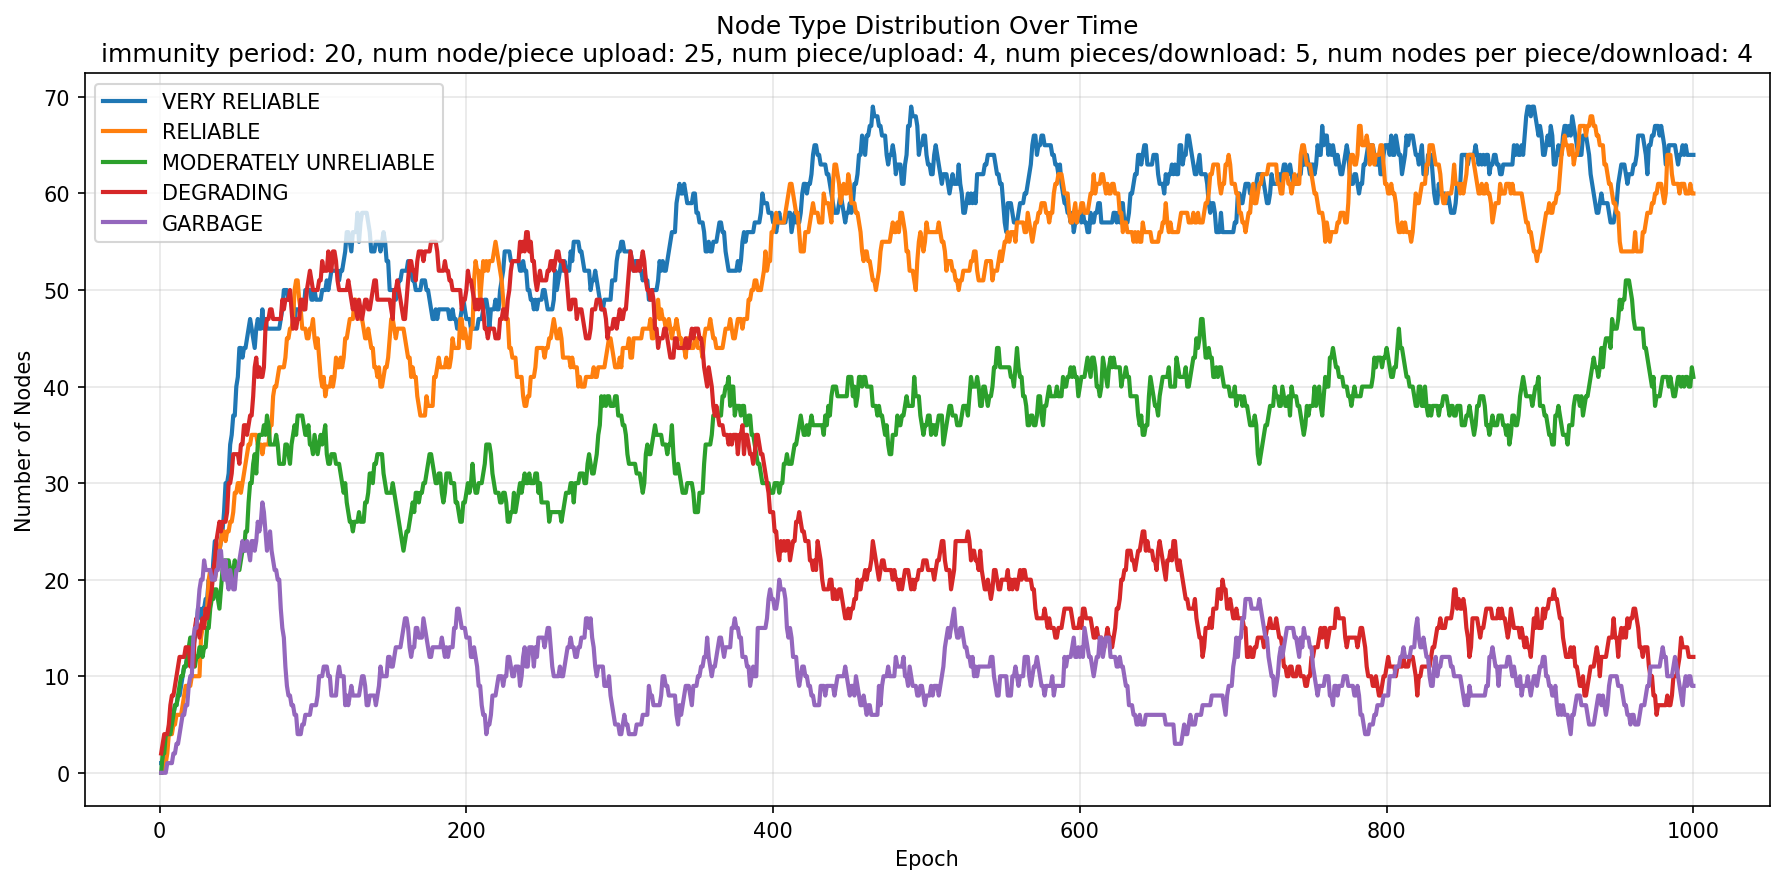

In [ ]:
# %%

# Plot distribution of the node types over time
def plot_node_type_distribution(result):
    """Plot the distribution of node types over time"""
    epoch_data = result["epoch_data"]

    # Extract epochs and node types
    epochs = [data["epoch"] for data in epoch_data]
    node_types = [data["nodes"] for data in epoch_data]

    # Create a mapping for reliability types
    reliability_map = {
        "VERY_RELIABLE": 1,
        "RELIABLE": 2,
        "MODERATELY_UNRELIABLE": 3,
        "DEGRADING": 4,
        "GARBAGE": 5,
    }

    # Initialize counts for each reliability type
    reliability_counts = {k: [] for k in reliability_map.keys()}

    # Count node types at each epoch
    for nodes in node_types:
        counts = {k: 0 for k in reliability_map.keys()}
        for node in nodes:
            counts[node["reliability"]] += 1
        for k in reliability_map.keys():
            reliability_counts[k].append(counts[k])

    # Create the plot
    plt.figure(figsize=(12, 6))
    for rel, counts in reliability_counts.items():
        plt.plot(epochs, counts, label=rel.replace("_", " "), linewidth=2)

    config = result["simulator"].config
    #     config = {
    #     "num_nodes_target": 192,
    #     "epochs": 1000,
    #     "nodes_per_epoch_add": 3,
    #     "nodes_per_epoch_churn": 3,
    #     "min_epochs_before_churn": 14,
    #     "num_nodes_per_piece_upload": 20,
    #     "num_piece_per_upload": 4,
    #     "num_pieces_download_per_audit": 5,
    #     "num_nodes_per_piece_download": 4,
    # }

    plt.title(
        f"Node Type Distribution Over Time\nimmunity period: {config['min_epochs_before_churn']}, num node/piece upload: {config['num_nodes_per_piece_upload']}, num piece/upload: {config['num_piece_per_upload']}, num pieces/download: {config['num_pieces_download_per_audit']}, num nodes per piece/download: {config['num_nodes_per_piece_download']}"
    )
    plt.xlabel("Epoch")
    plt.ylabel("Number of Nodes")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Plot the node type distribution
plot_node_type_distribution(result)